# Bagging: Random Forest



Emezaremos aplicando el modelo a un problema de clasificación, en concreto a nuestro querido dataset del Titanic. Aprovecharemos también para ver la parte de importancia de características  (o feature importance). 

#### **Clasificación**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/titanic_modified.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   MissingAge  891 non-null    int64  
 7   Spouse      891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


Es un dataset preparado para este notebook, para no tener que limpiar ni transformar features (fijate que son todos ya datos numéricos), pero recuerda que no será así en la realidad. Vamos con el split.

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Survived'])
y = df.Survived

classes = X.columns.values.tolist() # Nos quedamos con las features para luego ver la importancia de cada una

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=55)

In [3]:
y.value_counts(normalize = True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Sabemos que no está perfectamente balanceado o equilibrado, pero como es un ejercicio ilustrativo seguiremos adelante.

Antes de pasar a instanciar el modelo y entrenarlo un pequeño recordatorio gráfico de como funciona el algoritmo de bagging mediante Random Forest

## Random Forest

![Captura de pantalla 2024-01-29 111109.png](<attachment:Captura de pantalla 2024-01-29 111109.png>)
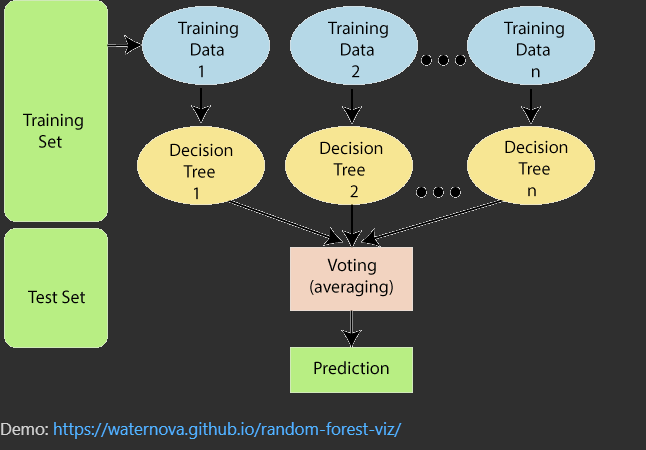

Demo: https://waternova.github.io/random-forest-viz/

Aquí un recuedo de los mecanismos de elección de la predicción: (recuerda que Random Forest en clasificación en sklearn usa soft voting)

![Captura de pantalla 2024-01-29 111138.png](<attachment:Captura de pantalla 2024-01-29 111138.png>)
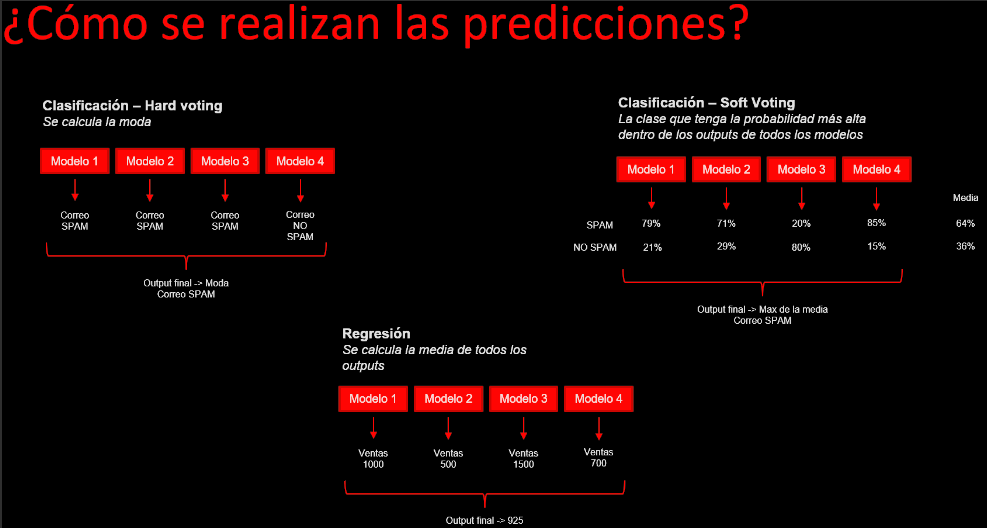

#### Modelado y entrenamiento

In [4]:
from sklearn.ensemble import RandomForestClassifier


rnd_clf = RandomForestClassifier(n_estimators=500,
                                max_depth=4,
                                random_state=42)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Antes de seguir, un detalle de implementación, si no se dice nada acerca de max_samples (número de máximo de instancias por train de submodelo), entonces cada submodelo ve un subdataset con un numero de instancias igual que el dataset original, pero ojo puede contener duplicados de instancias.

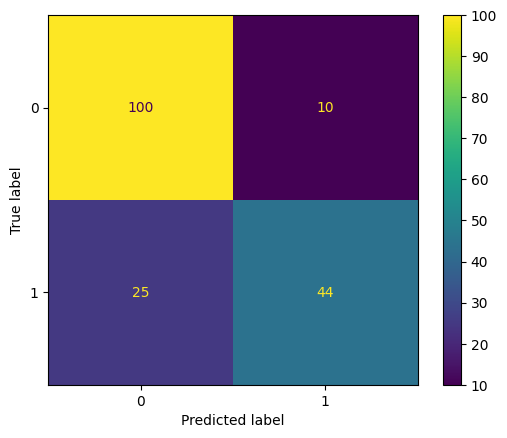

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

In [6]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       110
           1       0.81      0.64      0.72        69

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



Para lo seleccioando no tiene nada de mala pinta, aunque una logística igual hubiera obtenido más sin tocar un solo hiperparámetro, lo veremos al final del sprint.

### **Feature Importance**

Una característica interesante que tiene Random Forest es el **feature importance**. Nos da una medida de cuánto aporta cada feature a las predicciones. Se calcula para cada feature la aportación que ha hecho al gini o entropía. Para todos los árboles. Calculamos la media de la aportación de cada feature.

En cada split de los árboles se calcula el IG (Information Gained) teniendo en cuenta el índice Gini o la entropía antes y después del split. Se realiza una ponderación del IG en cada split

Por suerte sklearn ya realiza esta operación por nosotros, y lo normaliza a 1, de tal manera que las features más importantes estarán cercanas a 1 (el sumatorio de todas no es 1, no es un %).

In [7]:
rnd_clf.feature_importances_

array([0.23586492, 0.47903926, 0.12404398, 0.07216613, 0.06090722,
       0.01242875, 0.01554973])

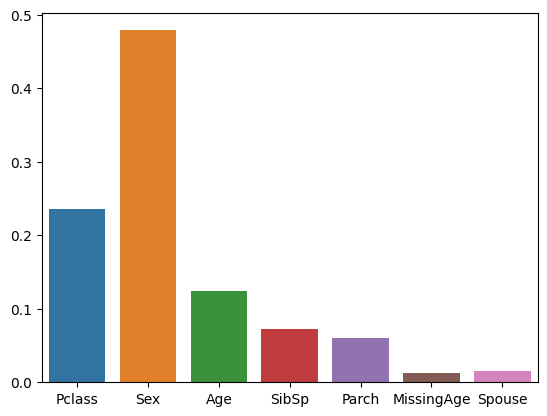

In [8]:
sns.barplot(x=classes, y=rnd_clf.feature_importances_, hue = classes);

### **Regresión**

Aplicamos ahora RandomForest a un problema de regresión, con un dataset que también es familiar (aunque ligeramente diferente), sí vamos a predecir precios de casas. Carguemos el dataset (de nuevo preparado para no tener que hacer nada, un lujo solo para las clases y algunos ejercicios)

In [9]:
df_reg = pd.read_csv('data/USA_Housing.csv')
X_reg = df_reg.drop(columns=['Price','Address'])
y_reg = df_reg['Price']
df_reg.head(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\r\nLaurabury, NE 37..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\r\nLake Kathleen, ..."


Hacemos nuestro split:

In [10]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg,y_reg,
                                                                   test_size=0.2,
                                                                   random_state=55)

Instanciamos y entrenamos

In [11]:
from sklearn.ensemble import RandomForestRegressor


rnd_reg = RandomForestRegressor(n_estimators=500,
                               max_depth=5,
                               random_state=42)
rnd_reg.fit(X_train_reg, 
           y_train_reg)


RandomForestRegressor(max_depth=5, n_estimators=500, random_state=42)

Evaluamos, todavía usando test, ya entraremos en el momento en que esta primera "evaluación" será más una validación y la haremos con croos_validation

In [12]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np

y_pred_reg = rnd_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))




MAE: 130675.24633852691
RMSE: 164427.11046579998


Nuestro primer objetivo está cumplido, que vieras como se instancia un RandomForest para regresión (no muy diferente que para clasificación) y por eso, ahora no lo vamos a ver, pero esos valores dan un poco de susto, ¿no? Más de 100K dolares de error... Te dejo como ejercicio decidir sin preguntar a nadie si es un muy mal modelo o no lo es tanto.

### Hiperparámetros

La complejidad inherente a un esamblado de modelos, aunque sea un ensamblado de modelos del mismo tipo como son los que veremos nosotros, ya hace que sea importante gestionarlos a través de los hiperparámetros. En el caso de bagging con Random Forest vamos a tener los propios de los árboles que lo compenen y otros a nivel general del modelo ensamblado:

**¿Qué hiperparámetros debería tocar en el RandomForest?**
  
A nivel de modelo general:
1. `n_estimators`: número de árboles que participarán en las votaciones. Cuantos más mejor. NO producen overfitting. Cuanto más complejo es el dataset, mejor vendrá que haya muchos árboles. Más de 200 suele ser redundante.
2. `max_samples`: No se suele tocar, pero determina el porcentaje (si das un valor entre 0 y 1) o el número máximo de instancias que puede ver cada submodelo. Si no ponemos nada cada submodelo (como se ha comentado) ve tantos elementos en entrenamiento como elementos tenga el dataset de train, pero ojo, es con reposición (si no tocamos otro hiperparámetro :-)) y por lo tanto puede haber instancias replicadas. En general no lo vamos a tocar pero si alguna vez quieres forzar la debilidad de los submodelos puedes jugar a bajarlo progresivamente o a optimizarlo con rangos bajos y altos (es decir cercanos a 0.01 y 1.00)

A nivel de submodelo (de los árboles, observa que son genéricos, se aplica el mismo valor para cada árbol o submodelo), son iguales que en los árboles de decisión:  
  
4. `max_depth`: profundida de los árboles. Cuanto más profundos, más complejo es el modelo, pero menos generaliza. De  nuevo, cuanto más complejo es el problema, mayor profundidad necesitaremos. No más de 20/30 es lo normal.  
5. `max_features`: features a tener en cuenta en los splits del árbol. Cuanto más bajo, mejor generalizará y menos overfitting. Numero menor a la cantidad de features del dataset, sino dará error. Ojo porque por defecto está puesto a la raíz cuadrada del número total de features.  
6. `min_samples_split`: mínima cantidad de muestras en un nodo antes de ser spliteado. 2 por defecto. Números bajos suelen dar buenos resultados (<50). Cuanto más alto, mejor generaliza, pero más baja la precisión.  
7. `min_samples_leaf`: mínima cantidad de puntos permitidos en un `leaf node`, es decir, un nodo que no va a volver a ser spliteado. Valores bajos funcionan bien (<50).  

Importante FIJATE SIEMPRE en los valores por defecto de los hiperparámetros de los modelos que instancies. En el caso de los Random Forest de sklearn los árboles tienen libertad para overfittear lo que quieran si no tocas ninguno de sus hiperparámetros.


### Ajuste de hiperparámetros (ejemplo)

Para terminar vajos a ajustar los hiperparametros de los bosques que hemos creado en las celdas anteriores.

***Primero: Selección de la malla o "grid"***

Creamos el Grid o juego de hiperparámetros y rangos que queremos testar

In [13]:
param_grid_clf = { # Lo vamos a probar para el clasificador, con el regresor es equivalente pero los valores no serán los mismos (no tenemos por ejemplo el mismo nuúmero de muestras)
    "n_estimators": [100,200,400], # Tecnica del halving (doblamos o dividimos a la mitad)
    "max_depth": [2,4,8,None],
    "max_features": ["sqrt", "log2", None], # Vamos a probar diferente número de features en cada split
    "class_weight": ["balanced", None]
}

***Segundo: Selección del método o estrategia de búsqueda***

Vamos a emplear GridSearchCV porque a pesar del número de combinaciones, el tiempo de ejecución está dentro de un orden.

**Grid Search**

A pesar de lo comentado tenemos 3x4x3x2 combinaciones, es decir 72 modelos y vamos a usar una validación cruzada de 5 folds (cv = 5) o sea vamos a entrenar 360 modelos... Aquí los tiempos empiezan a ser importantes incluso para un modelo tan sencillo y con tan pocos datos (711 instancias) (un entrenamiento de 1 segundo ya nos llevaría a 6 minutos mínimo para esta optimización tan sencilla)

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_rf = RandomForestClassifier()

grid_models = GridSearchCV(clf_rf,
                           param_grid_clf,
                           scoring = "balanced_accuracy", # es el recall medio considerando el recall de cada clase
                           cv = 5
                          )

grid_models.fit(X_train, y_train)
                           

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [2, 4, 8, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [15]:
grid_models.best_params_

{'class_weight': 'balanced',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 400}

In [16]:
grid_models.best_score_

0.8118408220132357

In [17]:
best_model = grid_models.best_estimator_

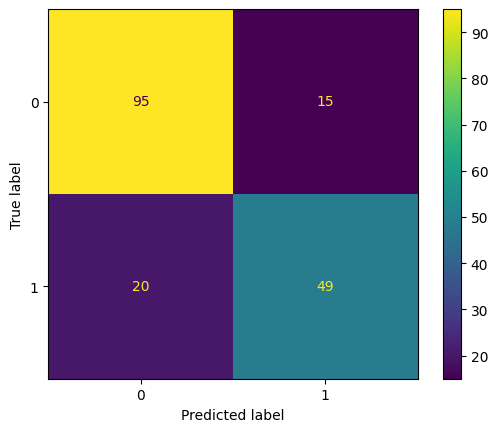

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test))

In [19]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [20]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       110
           1       0.81      0.64      0.72        69

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



In [21]:
### ANEXO: Metricas sklearn ###

from sklearn.metrics import get_scorer_names
get_scorer_names()


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

# Boosting Práctico

Primero vamos a cargar y a preparar minimamente (split de test y train) los dos datasets que vamos a emplear: titanic para clasificación y USA_Housing para regresión.

**Clasificación**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/titanic_modified.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   MissingAge  891 non-null    int64  
 7   Spouse      891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Survived'])
y = df.Survived

classes = X.columns.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=55)

**Regresión**

In [24]:
df_reg = pd.read_csv('data/USA_Housing.csv')
X_reg = df_reg.drop(columns=['Price','Address'])
y_reg = df_reg['Price']
df_reg.head(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\r\nLaurabury, NE 37..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\r\nLake Kathleen, ..."


In [25]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg,y_reg,
                                                                   test_size=0.2,
                                                                   random_state=55)

### Algoritmos de Boosting (I): AdaBoost y GradientBoost

En esta técnica los modelos van intentando mejorar su predecesor, recibiendo los errores del mismo, e intentando mejorar su resultado

Estos algoritmos son de los más poderosos cuando trabajamos con datos tabulares



## AdaBoost

AdaBoost (adaptive boosting) consiste en crear varios predictores sencillos en secuencia, de tal manera que el segundo ajuste bien lo que el primero no ajustó, que el tercero ajuste un poco mejor lo que el segundo no pudo ajustar y así sucesivamente. 

![Captura de pantalla 2024-01-29 150228.png](<attachment:Captura de pantalla 2024-01-29 150228.png>)  

Más info: https://youtu.be/LsK-xG1cLYA
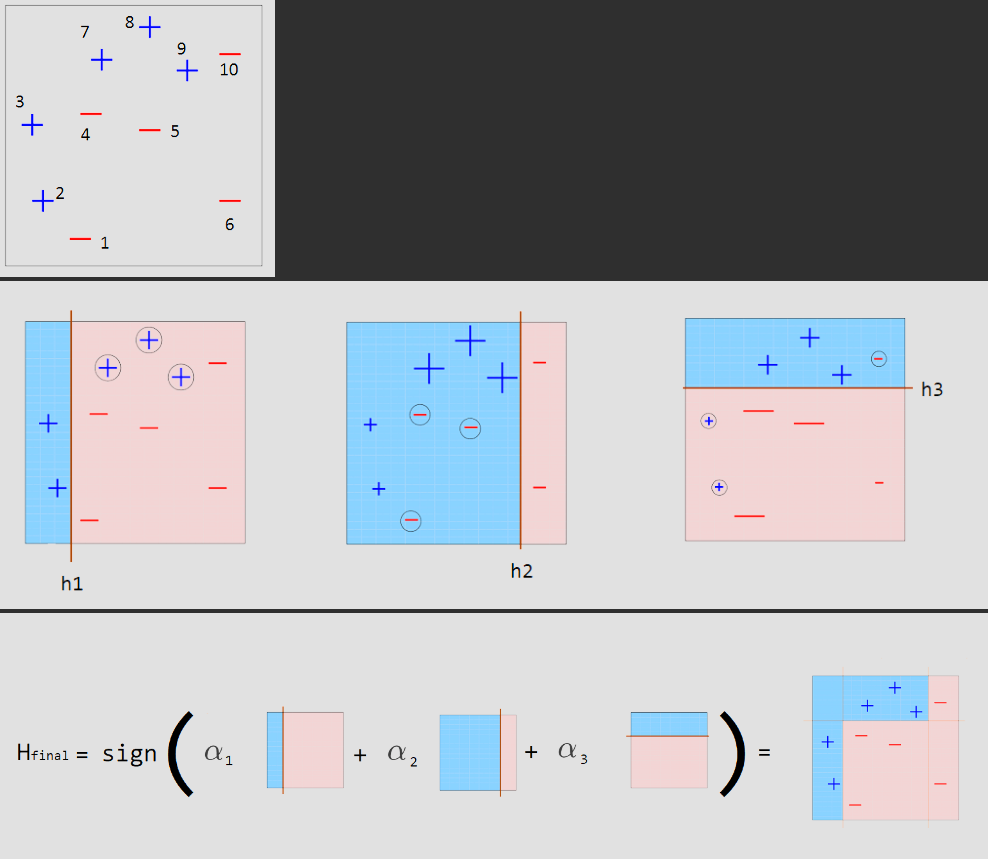

**AdaBoostClassifier**

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

ada_clf = AdaBoostClassifier(n_estimators=200, random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



**¿Qué hiperparámetros debería tocar en el AdaBoostClassifier?**

1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos. Este es el valor que generalmente tocaremos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. En general, no lo tocaremos.
3. `estimator`: se suele dejar por defecto, aunque podría encajar un SVM o una RegresiónLogística. En general, tampoco lo tocaremos. Ah y hay que pasarle un objeto del tipo de modelo que quieras emplear.

No, no hay hiperparámetros para los árboles internos. Recuerda que son "stumps" o tocones, árboles binarios con un único nivel de profundidad, no hay más que tocar. 

Antes de hacer una optimización, veamos la regresión con AdaBoostRegressor (que realmente se centra en poner pesos a los errores en la regresión de los modelos anteriores, por lo menos en [la implementación de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor), que implementa el algoritmo conocido como AdaBoost.R2)

**AdaBoostRegressor**

In [27]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

ada_reg = AdaBoostRegressor(n_estimators=200,
                               random_state=42)
ada_reg.fit(X_train_reg, 
           y_train_reg)

y_pred_reg = ada_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))


MAE: 100947.80757390938
RMSE: 130082.4839115346


Puede comparar con sesiones anteriores y verás que es un error menor que en RandomForest (sin optimizar hiperparámetros)

#### Optimización de hiperparámetros


In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    "n_estimators": [100,400],
    "learning_rate": [0.1,1,3.2]
}

model_grid = GridSearchCV(ada_reg,
                          param_grid= param_grid,
                          cv = 5,
                          scoring = "neg_mean_squared_error") # Se intenta maximizar el scoring por eso cuando la métrica es mejor cuando es más baja hay que usar las negadas

model_grid.fit(X_train_reg,y_train_reg)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(n_estimators=200, random_state=42),
             param_grid={'learning_rate': [0.1, 1, 3.2],
                         'n_estimators': [100, 400]},
             scoring='neg_mean_squared_error')

In [29]:
model_grid.best_params_

{'learning_rate': 3.2, 'n_estimators': 400}

In [30]:
np.sqrt(-model_grid.best_score_)

128959.73670565053

## GradientBoosting

Al igual que el AdaBoost, el GradientBoost trabaja sobre un conjunto secuencial de modelos (árboles de decisión), tratando de corregir a su predecesor. Sin embargo, cuando el AdaBoost iba actualizando los pesos de cada observación, el GradientBoosting intenta ajustar y minimizar los errores (residuos) del modelo predecesor.

El modelo final será una combinación lineal de todos los estimadores.



![Captura de pantalla 2024-01-29 150256.png](<attachment:Captura de pantalla 2024-01-29 150256.png>)
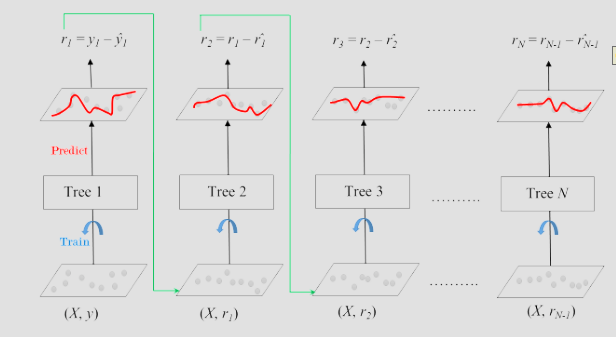

**GradientBoostingRegressor (cómo funciona, más o menos)**

Para exponer con un poco más de detalle el funcionamiento de los algoritmos de boosting, vamos a construir un problema muy similar al que usamos para ver los arboles de decisión aplicados a regresión y luego ese mismo problema lo vamos a resolver simulando un mecanismo de boosting.

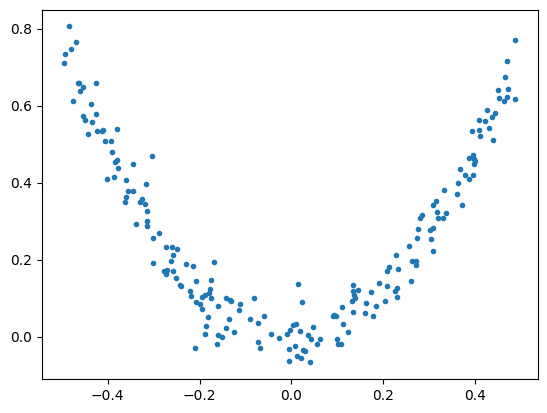

In [31]:
np.random.seed(42)
X = np.random.rand(200,1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(200)
X_test_sim = np.random.rand(100,1) - 0.5
y_test_sim = 3*X_test_sim[:, 0]**2 + 0.05 * np.random.randn(100)
plt.plot(X,y,'.')

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [33]:
y2 = y - tree_reg1.predict(X)

In [34]:
tree_reg2 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
X_new = np.array([[0.8]])
y_pred = sum([tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)])

In [37]:
y_pred_sim = sum([tree.predict(X_test_sim) for tree in (tree_reg1, tree_reg2, tree_reg3)])


In [38]:
y_tree_reg1_pred = tree_reg1.predict(X_test_sim)

In [39]:
print("MAE, arbol 1:", mean_absolute_error(y_test_sim, y_tree_reg1_pred))
print("MAE, sim GBT:", mean_absolute_error(y_test_sim, y_pred_sim))

MAE, arbol 1: 0.10329841215879393
MAE, sim GBT: 0.06395037885778372


Pintemos como está trabajando nuestro boosting de tres árboles:

In [40]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

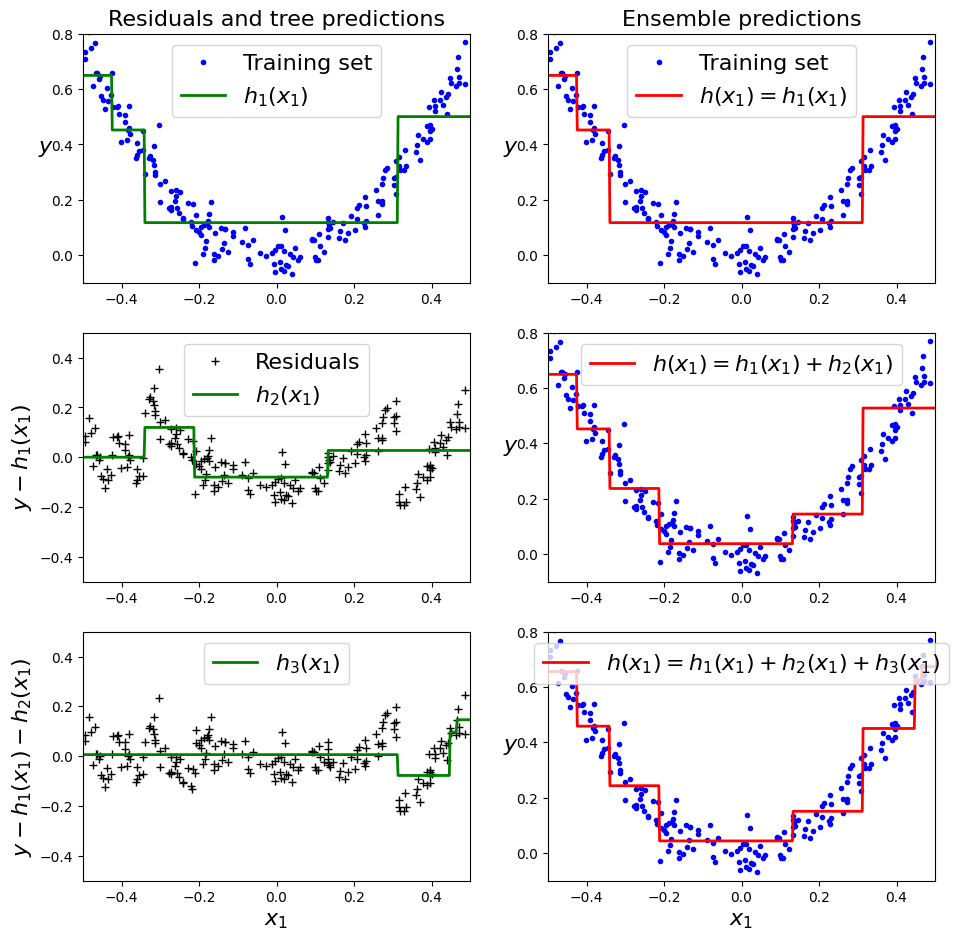

In [41]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

El truco del gradient reside en lo siguiente:

$$\hat y = \alpha_1h_1(x_) + \alpha_2h_2(x) + \alpha_3h_3(x) + ....$$

Es decir ahora tienen unos pesos y esos pesos se obtienen de aplicar gradiente descendente al error cuadrático medio de $y_{real}$ con $\hat y$. Es decir en este tipo de algoritmos no sólo son parámetros los puntos de cortes de cada uno de los árboles sino también el coeficiente que determina el peso de cada árbol en la decisión final.

Y ahora ya sí:

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() 

gbr.fit(X_train_reg, y_train_reg)
y_pred = gbr.predict(X_test_reg)

print("MAE:", mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 85550.98776896918
RMSE: 106434.51271746648


Mucho mejor, eh... Sí ya vas saboreando el poder del boosting. Veamos si también podemos tocarlo ya en clasificación.

**GradientBoostingClassifier**

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



La mejora no es tan evidente (de hecho en algún caso no la hay, no el recall_medio), pero mejora el accuracy medio de los modelos ajustados de RandomForest,... pero este sin ajustar. 

**¿Qué hiperparámetros debería tocar en el GradientBoosting?**

Como los RandomForest, los GBT basados en árboles tienen hiperparámetros de modelo y tienen hiperparámetros de submodelo:

De modelo:
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.

Observa que al incorporar un mecanismo de optimización de función de perdida (el gradiente descendente sobre el error cuadrático medio) incluye al menos un hiperparámetro de learning_rate, pero también tiene otros relacionados (que no vamos a profundizar, como tolerance (tol) o máximo número de iteraciones)

De submodelo (árboles de decisión):

3. `max_depth`: profundida de los árboles. Cuanto más profundos, más complejo es el modelo, pero menos generaliza. De  nuevo, cuanto más complejo es el problema, mayor profundidad necesitaremos. No más de 20/30 es lo normal.  
4. `max_features`: features a tener en cuenta en los splits del árbol. Cuanto más bajo, mejor generalizará y menos overfitting. Numero menor a la cantidad de features del dataset, sino dará error. Ojo porque por defecto está puesto a la raíz cuadrada del número total de features.  
5. `min_samples_split`: mínima cantidad de muestras en un nodo antes de ser spliteado. 2 por defecto. Números bajos suelen dar buenos resultados (<50). Cuanto más alto, mejor generaliza, pero más baja la precisión.  
6. `min_samples_leaf`: mínima cantidad de puntos permitidos en un `leaf node`, es decir, un nodo que no va a volver a ser spliteado. Valores bajos funcionan bien (<50).  



## Algoritmos de Boosting (II): XGBoost, LightGBM, CatBoost

Como ya sabes una de las limitacioones de los algoritmos de boosting es que los modelos entrenan secuencialmente, no hay otra forma de hacerlo y eso hace que de primeras sean lentos. Por eso con el tiempo han surgido implementaciones del GBT que han buscado acelerar los procesos sobre todo en los entrenamientos de los submodelos intermedios (por ejemplo la obtención de los valores de corte de las features de ramas diferentes en un arbol se pueden hacer en paralelo, o las variables numérica se pueden binnear y eso acelera el proceso de obtención de valores y no afecta excesivamente al árbol).  

Tres implementaciones "ganan" a día de hoy y son las que vamos a ver, que no solo son más rápidas que un GBT sino que además añaden sus "cositas".


## XGBoost
[XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (exTreme Gradient Boosting) es un algoritmo que se enfoca en la velocidad de computación y el desempeño del modelo. Hace especial hincapié en la regularización (con una forma particular de aplicar penalización a la función de pérdida) y en cómo construir los árboles en cada submodelo. 


XGBoost permite regularizar el modelo y puede manejar missings, por lo que no es necesario tener el dataset perfectamente limpio

**XGBRegressor**


In [44]:
import xgboost

xgb_reg = xgboost.XGBRFRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred = xgb_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 117658.7443716505
RMSE: 148598.80333071738


**XGBClassifier**

In [45]:
xgb_clas = xgboost.XGBClassifier(random_state=42)

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



**¿Qué hiperparámetros debería tocar en el XGB?**

Parámetros del modelo:

1. `n_estimators`: igual que para el GradientBoosting. Un detalle es que el número de submodelos puede ser menor
2. `learning_rate`: o también llamado `eta`. Como el learning rate del GradientBoosting, sirve para modular el aporte de cada nuevo arbol que se añade a la secuencia. Tiene el mismo comportamiento que un learning_rate en otros modelos, a mayor valor más rápido converge menor es la capacidad de predicción, a menor valor más tarda en converger, mayor es la capacidad (en general) y se corre el riesgo de overfitting.
- `scale_pos_weight`: es un factor de escala para aplicar a la función de pérdida para los casos en clasificación en las que el dataset está desbalanceado.

Parámetros de los submodelos:

3. `max_depth`: máximo nivel de profundidad de los árboles.
4. `min_child_weight`: equivalente a "min_sample_split" en otros modelos con árboles de sklearn.
5. `subsample`: muestreo del dataset para cada árbol (equivalente a max_samples en Random Forest)
6. `colsample_bytree`: fracción del total de variables por árbol (con un objetivo más o menos similar al "max_features" en Random Forest)

Si quieres afinar más todavía el XGBoost consulta [esta completa guía](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

Vamos a completar la lista de modelos y al final haremos la optimización de hiperparámetros para los tres

## LightGBM  

Similar a XgBoost, desarrollado por Microsoft, es ligeramente más rápido que el resto de los que vamos a ver en esta sesión. Sin entrar en muchos detalles tiene una forma diferente de construcción de los árboles que le hace más rápido con grandes volúmenes. En general, puede generalizar peor que XGBoost que incluye la regularización como algo estándar. Maneja variables categóricas sin procesar aunque no tan bien como lo hace CatBoost. 


**LGBMRegressor**

In [46]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train_reg, y_train_reg)
y_pred = lgbm_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 5
[LightGBM] [Info] Start training from score 1232594.044782
MAE: 87803.38881114805
RMSE: 109959.13432006085


**LGBMClassifier**

In [47]:
df_t = pd.read_csv("./data/titanic.csv")

In [48]:
df_t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
features_lgbm = ["Pclass","Sex","Embarked","Age","Fare"]
features_cat = ["Sex","Embarked"]

In [50]:
df_t["Sex"] = df_t["Sex"].astype("category")
df_t["Embarked"] = df_t["Embarked"].astype("category")

In [51]:
df_t.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [52]:
train_set, test_set = train_test_split(df_t, test_size=0.2, random_state= 42)

In [53]:
X_train_lgbm = train_set[features_lgbm]
y_train_lgbm = train_set["Survived"]

X_test_lgbm = test_set[features_lgbm]
y_test_lgbm = test_set["Survived"]

In [54]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
lgbm_clas = LGBMClassifier(random_state=42)

lgbm_clas.fit(X_train_lgbm, y_train_lgbm, categorical_feature= features_cat)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(random_state=42)

In [55]:
y_pred_lgbm = lgbm_clas.predict(X_test_lgbm)
print(classification_report(y_test_lgbm, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179





**¿Qué hiperparámetros debería tocar en el LightGBM?**
Relacionados con el modelo en general:
- `n_estimators`: Número de submodelos o estimadores máximos que contendrá mi modelo ensamblado final.
- `learning_rate`:  Tasa de aprendizaje. Un valor más pequeño significa un entrenamiento más lento pero puede mejorar la precisión del modelo. Un valor alto acelera el entrenamiento pero puedes perder precisión o capacidad (posibilidad de no converger al óptimo correcto)
- `max_bin`: Controla el número máximo de bins en los que se dividen las variables numéricas continuas para acelerar la generación de árboles. Por defecto está a 255.

Relacionados con los submodelos:
1. `max_depth` – Similar to XGBoost, this parameter instructs the trees to not grow beyond the specified depth. A higher value increases the chances for the model to overfit.
2. `num_leaves` – This parameter is very important in terms of controlling the complexity of the tree. The value should be less than 2^(max_depth) as a leaf-wise tree is much deeper than a depth-wise tree for a set number of leaves. Hence, a higher value can induce overfitting.
3. `min_data_in_leaf` – The parameter is used for controlling overfitting. A higher value can stop the tree from growing too deep but can also lead the algorithm to learn less (underfitting). According to the LightGBM’s official documentation, as a best practice, it should be set to the order of hundreds or thousands.
4. `feature_fraction` – Similar to colsample_bytree in XGBoost
5. `bagging_fraction` – Similar to subsample in XGBoost

## Catboost

Su nombre combina *Category* y *Boosting*, y funciona bien cuando tenemos muchas variables categóricas (de hecho, [las admite como inputs](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)) y texto (veremos en futuros sprints como tratar variables tipo texto libre, es decir frases, párrafos en lenguaje natural, etc)

In [56]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [57]:
X = df.drop(columns=['price'])
y = df.price

In [58]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,test_size=0.2,
                                                       random_state=1)

In [59]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )
pool_train = Pool(X_train2, y_train2,
                 cat_features=['cut','color','clarity'])

pool_test = Pool(X_test2, cat_features=['cut','color','clarity'])

cb.fit(pool_train)
y_pred = cb.predict(pool_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test2,y_pred)))

RMSE: 529.5700855716823


In [60]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations = 200,
                        learning_rate = 0.9,
                        verbose = False)
pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test)
cb.fit(pool_train)

In [61]:
y_pred_cat = cb.predict(pool_test)
print(classification_report(y_test,y_pred_cat))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.76      0.64      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



#### Hiperparámetros:

CatBoost ofrece una variedad de hiperparámetros para controlar el entrenamiento del modelo y mejorar su rendimiento. Algunos de los hiperparámetros más importantes son:

Del modelo:
- `iterations`: Número de árboles a entrenar. Es equivalente a `n_estimators` en otros modelos de boosting.
- `l2_leaf_reg`: Coeficiente para el término de regularización L2 del coste. Puede ser utilizado para balancear la sobre-adaptación del modelo.
- `border_count`: Número de divisiones para características numéricas. Es similar a `max_bin` en LightGBM. (XGBoost, Catboost y LightGBM hacen binning de las variables numéricas y usa los índices en vez de las valores reales para hacer los árboles internos, por eso el número de bins o "categorias" para discretizar los valores numéricos es un hiperparámetro)
- `cat_features`: Índices de características categóricas. CatBoost manejará estas características internamente, convirtiéndolas de manera óptima. [OJO ESTE NO ES UN HIPERPARAMETRO EN EL MISMO SENTIDO CON EL QUE TRATAMOS AL RESTO, pero permite emplearla como hiperparámetro en vez de hacer feature selection en el train]
- `learning_rate`: Tasa de aprendizaje del algoritmo. Un valor más bajo hace que el modelo sea más robusto a la sobre-adaptación, pero puede requerir más iteraciones.

De los árboles:
- `depth`: Profundidad de los árboles. Controla la complejidad del modelo. (Como `max_depth` en otros modelos basados en árboles)


### Ajuste de hiperparámetros
Con todos los algoritmos vistos en este notebook, es posible aplicar la optimización de hiperparámetros, utilizando las técnicas que vimos anteriormente

In [62]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost 

params_xgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': [0.3,0.6,1],
          'colsample_bytree': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          }

xgb = xgboost.XGBRegressor()

clf = RandomizedSearchCV(estimator=xgb,
                        cv=4,
                        n_iter=10,
                        param_distributions=params_xgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.5, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [3, 6, 12],
                                        'n_estimators': [100, 250, 500, 750],
                                        'subsample': [0.3, 0.6, 1]},
                   scoring='neg_mean_squared_error')

In [63]:
clf.best_params_

{'subsample': 0.6,
 'n_estimators': 250,
 'max_depth': 3,
 'learning_rate': 0.3,
 'colsample_bytree': 0.5}

In [64]:
y_pred = clf.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 91017.92088803658
RMSE: 112588.4440622


#### Para LightGBM

In [65]:

params_lgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb = LGBMRegressor()

clf = RandomizedSearchCV(estimator=lgb,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_lgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

RandomizedSearchCV(cv=4, estimator=LGBMRegressor(), n_iter=2,
                   param_distributions={'bagging_fraction': [0.3, 0.6, 1],
                                        'feature_fraction': [0.5, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_bins': [125, 250],
                                        'max_depth': [3, 6, 12],
                                        'n_estimators': [100, 250, 500, 750]},
                   scoring='neg_mean_squared_error')

In [66]:
clf.best_params_

{'n_estimators': 100,
 'max_depth': 6,
 'max_bins': 125,
 'learning_rate': 0.1,
 'feature_fraction': 1,
 'bagging_fraction': 1}

#### Para CatBoost


In [67]:



params_cat = {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }

cat_model = CatBoostRegressor(verbose = False)

clf = RandomizedSearchCV(estimator=cat_model,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_cat,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)


RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002CDD8943E50>,
                   n_iter=2,
                   param_distributions={'border_count': [125, 250],
                                        'colsample_bylevel': [0.5, 1],
                                        'depth': [3, 6, 12],
                                        'iterations': [100, 250, 500, 750],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4]},
                   scoring='neg_mean_squared_error')

In [68]:
clf.best_params_

{'learning_rate': 0.3,
 'iterations': 750,
 'depth': 3,
 'colsample_bylevel': 0.5,
 'border_count': 250}

En los ejercicios veremos un par de hiperparámetros relacionados con la técnica de histogram gradient boosting para LightGBM y CatBoost. 

### Tabla comparativa cuándo usar cuál modelo

# Tabla comparativa: Elección de algoritmos de boosting

| Característica / Algoritmo | Gradient Boosted Trees (sklearn) | XGBoost | CatBoost | LightGBM |
|----------------------------|----------------------------------|---------|----------|----------|
| **Manejo de grandes conjuntos de datos** | Menos eficiente | Eficiente | Eficiente | Muy eficiente |
| **Velocidad de entrenamiento** | Rápido | Muy rápido | Rápido | Muy rápido |
| **Uso de recursos computacionales** | Moderado | Moderado/Alto | Moderado | Bajo |
| **Manejo de características categóricas** | Requiere pre-procesamiento | Requiere pre-procesamiento | Excelente (soporte nativo) | Bueno (soporte nativo) |
| **Rendimiento con configuración por defecto** | Bueno | Bueno | Excelente | Bueno |
| **Prevención de sobreajuste** | Bueno (con ajuste de hiperparámetros) | Bueno (con ajuste de hiperparámetros) | Excelente | Bueno |
| **Soporte para optimización de hiperparámetros** | Amplio | Amplio | Amplio | Amplio |
| **Facilidad de uso e integración** | Alta (especialmente con el ecosistema de sklearn) | Alta | Alta | Alta |
| **Popularidad y comunidad** | Alta | Muy alta | Alta | Alta |

**Nota**: Esta tabla proporciona una visión general y las decisiones deben basarse en pruebas empíricas y requisitos específicos del proyecto.


**Lecturas recomendadas**:

[When to Choose CatBoost Over XGBoost or LightGBM](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm)

[XGBoost vs LightGBM: How Are They Different](https://neptune.ai/blog/xgboost-vs-lightgbm)

[XGBoost: Everything You Need to Know](https://neptune.ai/blog/xgboost-everything-you-need-to-know)

[Understanding LightGBM Parameters (and How to Tune Them)](https://neptune.ai/blog/lightgbm-parameters-guide)

## Comparación Modelos: Clasificación

Importamos las librerías necesarias y los datos para poder comparar diferentes modelos sobre un mismo problema de clasificación. En este caso el problema consiste en clasificar una serie de vinos italianos en función de varias propiedades químicas de estos. Es un dataset sencillo para que los modelos no tarden en entrenarse, pero dado el escaso número de instancias no es el mejor ejemplo para aplicar determinados algoritmos que tienden a sobreajustarse con pocos datos.

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [69]:
df = pd.read_csv("./data/vinos_italianos.csv")

In [70]:
df.head()

,wine_class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   wine_class                    178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [72]:
target = "wine_class"

In [73]:
df[target].value_counts(normalize= True)

wine_class
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64

Es un dataset equilibrado, limpio y preparado al que únicamente tendremos que escalar las variables para los modelos sensibles a dicha escala en nuestro caso la regresión logística

In [74]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [77]:
features = train_set.columns.to_list()
features.remove(target)
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set[target] - 1
X_test = test_set[features]
y_test = test_set[target] - 1
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

### Modelos  

Vamos a escoger todos los modelos que hemos visto de clasificación y los vamos a probar todos:

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]


### Comparación con Validación Cruzada (pre-optimización)


In [82]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre != "Logistic Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)


In [83]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <Logistic Regression>, Accuracy_CV: 0.978871158392435
Model <DecisionTree>, Accuracy_CV: 0.9222813238770685
Model <Random Forest>, Accuracy_CV: 0.9858156028368793
Model <XGBoost>, Accuracy_CV: 0.9645390070921986
Model <LightGBM>, Accuracy_CV: 0.9716312056737588
Model <CatBoost>, Accuracy_CV: 0.9787234042553191
El ganador es Random Forest


### Optimizacion del Ganador


In [84]:

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [85]:
rf_grid.best_score_

0.9858156028368793

In [86]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': 'sqrt',
 'max_samples': 0.6,
 'min_samples_leaf': 10,
 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.86      0.92        14
           2       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



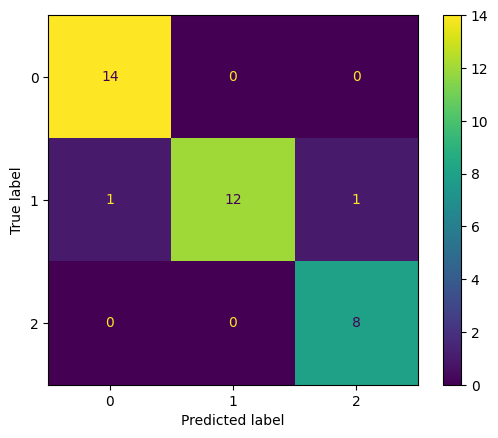

In [87]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Comparación con Optimización previa

Una alternativa a hacer una validación cruzada sin optimizar es hacer una comparativa de modelos semi-optimizados mediante una estrategia de RandomSearch.  
La idea es combinar la capacidad de comparativa de la validación cruzada pero haciendo que los modelos puedan aprovechar relativamente un poco de optimización de hiperparámetros y no hacerlo a la primera con cada uno.


In [88]:
metricas_optimizadas = {}

In [89]:
### Logistic Regression
LogisticRegression
param_grid = {
    "max_iter": [1000, 2000, 5000, 10000],
    "penalty": ["l2",None],
    "C": [0.1,0.5,1],

} # 4*3*3 -> 36 modelos
model = LogisticRegression()
lr_grid = RandomizedSearchCV( model,
                             cv = 3, # 36*3 -> 108 entrenamientos en gridsearch
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "accuracy"
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", lr_grid.best_score_)
metricas_optimizadas["LogisticRegression"] = lr_grid.best_score_

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_rati

LR best_score: 0.9859633569739952


In [90]:
### DecisionTrees

tree_clf = DecisionTreeClassifier()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")

tree_grid.fit(X_train,y_train)
print("Tree best_score:", tree_grid.best_score_)
metricas_optimizadas["Tree"] = tree_grid.best_score_

Tree best_score: 0.9222813238770685


In [91]:
### RandomForest

rf_clf = RandomForestClassifier()

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


rf_grid.fit(X_train, y_train)
print("RF best_score:", rf_grid.best_score_)
metricas_optimizadas["RandomForest"] = rf_grid.best_score_

RF best_score: 0.9787234042553191


In [92]:
### XGBoost

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

XGB best_score: 0.9858156028368793


In [93]:
### LightGBM 


lgb_clf = LGBMClassifier(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", lgb_grid.best_score_)
metricas_optimizadas["LightGBM"] = lgb_grid.best_score_

LGB best_score: 0.9929078014184397


In [94]:
### CatBoost

cat_clf = CatBoostClassifier(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", cat_grid.best_score_)
metricas_optimizadas["CatBoost"] = cat_grid.best_score_

CatBoost best_score: 0.9787234042553191


## Comparación Modelos: Regresión

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [96]:
df = pd.read_csv("./data/auto_prices.csv")

In [97]:
df.head()

,fuel_type,num_doors,body_style,wheel_base,engine_size,bore,stroke,horsepower,peak_rpm,city_mpg,...,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo
0,0.0,2,0.0,88.6,130,3.47,2.68,111,5000,21,...,0,0,0,0,0,0,0,0,0,0
1,0.0,2,0.0,88.6,130,3.47,2.68,111,5000,21,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2,1.0,94.5,152,2.68,3.47,154,5000,19,...,0,0,0,0,0,0,0,0,0,0
3,0.0,4,2.0,99.8,109,3.19,3.40,102,5500,24,...,0,0,0,0,0,0,0,0,0,0
4,0.0,4,2.0,99.4,136,3.19,3.40,115,5500,18,...,0,0,0,0,0,0,0,0,0,0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           193 non-null    float64
 1   num_doors           193 non-null    int64  
 2   body_style          193 non-null    float64
 3   wheel_base          193 non-null    float64
 4   engine_size         193 non-null    int64  
 5   bore                193 non-null    float64
 6   stroke              193 non-null    float64
 7   horsepower          193 non-null    int64  
 8   peak_rpm            193 non-null    int64  
 9   city_mpg            193 non-null    int64  
 10  highway_mpg         193 non-null    int64  
 11  price               193 non-null    int64  
 12  make_alfa-romero    193 non-null    int64  
 13  make_audi           193 non-null    int64  
 14  make_bmw            193 non-null    int64  
 15  make_chevrolet      193 non-null    int64  
 16  make_dod

In [99]:
target = "price"

<Axes: xlabel='price', ylabel='Count'>

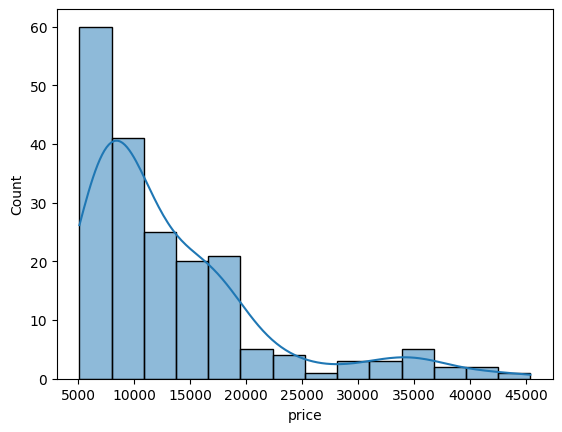

In [100]:
sns.histplot(x= "price", data = df, kde = True)

Es un dataset limpio y preparado al que únicamente tendremos que escalar las variables para los modelos sensibles a dicha escala en nuestro caso la regresión lineal. Además el target está topado porque hay un precio mínimo (quizás sería intersante hacer un modelo contra el logaritmo del target y luego transformalo de vuelta)

In [101]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

Por sencillez, no vamos a transformar las variables, sólo vamos a escalarlas, deberíamos hacer un pequeño estudio de cada potencial feature y ver que transformación/escalado es el más adecuado...

In [102]:
features = train_set.columns.to_list()
features.remove(target)
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set[target]
y_log_train = train_set[target].apply(np.log)
X_test = test_set[features]
y_test = test_set[target]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

### Modelos

Vamos a escoger todos los modelos que hemos visto de regresión y los vamos a probar todos:

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]


### Comparación con Validación Cruzada (pre-optimización)


In [104]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "neg_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [105]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 2687.814705024132
Model <DecisionTree>, RMSE_CV: 3332.2421904449325
Model <Random Forest>, RMSE_CV: 2589.5047373415387
Model <XGBoost>, RMSE_CV: 2900.5140359162247
Model <LightGBM>, RMSE_CV: 3837.6938192970165
Model <CatBoost>, RMSE_CV: 3251.0555613918264
El ganador es Random Forest


### Optimizacion del Ganador


In [106]:

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    #"min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "neg_mean_squared_error",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_squared_error')

In [107]:
np.sqrt(-rf_grid.best_score_)

2473.553103854178

In [108]:
rf_grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_samples': 0.6,
 'n_estimators': 400}

In [109]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 1490.3303366809478
MAPE: 0.095288118211499
RMSE: 2609.4773942960474


### Comparación con Optimización previa

Una alternativa a hacer una validación cruzada sin optimizar es hacer una comparativa de modelos semi-optimizados mediante una estrategia de RandomSearch.  
La idea es combinar la capacidad de comparativa de la validación cruzada pero haciendo que los modelos puedan aprovechar relativamente un poco de optimización de hiperparámetros y no hacerlo a la primera con cada uno.


In [110]:
metricas_optimizadas = {}

In [111]:
### Linear Regresion
from sklearn.linear_model import ElasticNet

param_grid = {
    "alpha": [0.1, 1, 10, 100],
    "l1_ratio": [0.2,0.4,0.6,1]

} 
model = ElasticNet()
lr_grid = RandomizedSearchCV( model,
                             cv = 3, 
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "neg_mean_squared_error"
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", np.sqrt(-lr_grid.best_score_))
metricas_optimizadas["Linear Regresion"] = np.sqrt(-lr_grid.best_score_)

LR best_score: 2581.409088678897


c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+06, tolerance: 6.010e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+06, tolerance: 4.616e+05
  model = 

In [112]:
### DecisionTrees

tree_clf = DecisionTreeRegressor()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")

tree_grid.fit(X_train,y_train)
print("Tree best_score:", np.sqrt(-tree_grid.best_score_))
metricas_optimizadas["Tree"] = np.sqrt(-tree_grid.best_score_)

Tree best_score: 3090.938987575256


In [113]:
### RandomForest

rf_clf = RandomForestRegressor()

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


rf_grid.fit(X_train, y_train)
print("RF best_score:", np.sqrt(-rf_grid.best_score_))
metricas_optimizadas["RandomForest"] = np.sqrt(-rf_grid.best_score_)

RF best_score: 2686.126867020947


In [114]:
### XGBoost

xgb_clf = XGBRegressor()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))
metricas_optimizadas["XGBoost"] = np.sqrt(-xgb_grid.best_score_)

XGB best_score: 2609.8840201221956


In [115]:
### LightGBM 


lgb_clf = LGBMRegressor(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", np.sqrt(-lgb_grid.best_score_))
metricas_optimizadas["LightGBM"] = np.sqrt(-lgb_grid.best_score_)

LGB best_score: 3475.3712595886054


In [116]:
### CatBoost

cat_clf = CatBoostRegressor(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", np.sqrt(-cat_grid.best_score_))
metricas_optimizadas["CatBoost"] = np.sqrt(-cat_grid.best_score_)

CatBoost best_score: 3043.4597602648914
